In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.utils import check_array, safe_indexing, sparsefuncs_fast, check_X_y, check_random_state
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from numbers import Integral
from sklearn.svm import SVC
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE
import os
import missingpy as missingpy
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import pickle
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score

# Set folder paths for outputs

In [2]:
os.chdir('..')
REPO_ROOT = Path(os.getcwd())
DATA = Path(REPO_ROOT / 'data')
MODELS = Path(REPO_ROOT / 'model')
REPORTS = Path(REPO_ROOT / 'reports' / 'rain')

# Read the file

In [3]:
df= pd.read_csv(DATA / 'weatherAUS.csv')

In [4]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

#### As we can see Sunshine, Evaporation, Cloud3pm and Cloud9am have around 50% data, we can ignore these four columns We need to remove RISK_MM because we want to predict 'RainTomorrow' and RISK_MM can leak some info to our model We can remove location and date column too, because we are going to findwhich weather conditions affect chancess of rain

In [5]:
df.drop(columns=['Sunshine','Evaporation','Cloud3pm','Cloud9am','RISK_MM','Date','Location'],axis=1, inplace = True)

#### In order to feed the data to any machine learning method, it's convenient to change strings to numeric values. So, we are going to change 'No' to 0 and 'Yes' to 1

In [6]:
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.isnull().sum()

MinTemp            586
MaxTemp            277
Rainfall          1402
WindGustDir       9279
WindGustSpeed     9219
WindDir9am        9962
WindDir3pm        3727
WindSpeed9am      1297
WindSpeed3pm      2579
Humidity9am       1723
Humidity3pm       3559
Pressure9am      13963
Pressure3pm      13930
Temp9am            853
Temp3pm           2675
RainToday         1402
RainTomorrow         0
dtype: int64

In [9]:
df.shape

(142142, 17)

In [10]:
df.dropna(inplace=True)

In [11]:
df.shape

(112925, 17)

In [12]:
Counter(df.RainTomorrow)

Counter({0: 87906, 1: 25019})

In [13]:
df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir', 'WindGustSpeed',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

# Create helper functions

In [14]:
## evaluate function generates the classification report of the loaded model based on the list of x and y values

def evaluate(x, y, threshold):
    x = np.array(x)
    y = np.ravel(y)
    pred = (loaded_model.predict_proba(x)[:,1] >= threshold).astype(bool)
    print(pd.crosstab(y, pred, rownames=['Actual'], colnames=['Predicted']))
    print(classification_report(y, pred,digits=4))
    return None;

## generate_curves function creates ROC-AUC and PR-AUC curve of the loaded model and compare that wth the random classifier

def generate_curves(filename_old, filename_new, X_test, y_test):   

    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    loaded_model_old = pickle.load(open(filename_old, 'rb'))
    loaded_model_new = pickle.load(open(filename_new, 'rb'))

    test_prob_old = loaded_model_old.predict_proba(X_test)[:, 1]
    test_prob_new = loaded_model_new.predict_proba(X_test)[:, 1]
    
    fpr_old, tpr_old, _ = roc_curve(y_test,  test_prob_old)
    roc_auc_old = roc_auc_score(y_test,  test_prob_old)
    ax1.plot([0, 1], [0, 1], linestyle='--',label ='random, auc = %.4f'% 0.5, c = 'blue')
    ax1.plot(fpr_old, tpr_old ,label ='SMOTE-NC, auc = %.4f'% roc_auc_old, c= 'green')
    
    fpr_new, tpr_new, _ = roc_curve(y_test,  test_prob_new)
    roc_auc_new = roc_auc_score(y_test,  test_prob_new)
    ax1.plot(fpr_new, tpr_new ,label ='SMOTE-ENC, auc = %.4f'% roc_auc_new, c= 'red')
    
    ax1.legend(loc=4)

    ax1.set_title('ROC curve' ,fontsize=16)
    ax1.set_ylabel('True Positive Rate',fontsize=14)
    ax1.set_xlabel('False Positive Rate',fontsize=14)

    ax2 = f.add_subplot(122)
    

    precision_old, recall_old, _ = precision_recall_curve(y_test, test_prob_old)
    precision_new, recall_new, _ = precision_recall_curve(y_test, test_prob_new)
    
    auc_score_old = auc(recall_old, precision_old)
    auc_score_new = auc(recall_new, precision_new)
    
    random_auc = y_test.sum()/len(y_test)
    
    ax2.plot([0, 1], [random_auc, random_auc], linestyle='--', label ='random, auc = %.4f'% random_auc, c ='blue')
    ax2.plot(recall_old, precision_old, label = 'SMOTE-NC, auc=%.4f'% auc_score_old, c = 'green')
    ax2.plot(recall_new, precision_new, label = 'SMOTE-ENC, auc=%.4f'% auc_score_new, c = 'red')
    
    ax2.set_title('Precision Recall curve' ,fontsize=16)
    ax2.set_ylabel('Precision', fontsize=14)
    ax2.set_xlabel('Recall',fontsize=14)
    ax2.legend(loc='best')
    plt.show()
    f.savefig(REPORTS / 'rain_roc_prc.jpeg', bbox_inches='tight')
    
    return None;

In [15]:
## Split the data to be 5-fold cross-validated
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)

#randomforest model - hyperparameter tuning using grid search

param_grid = {
'max_depth': [7, 10], 'max_features': [7, 12],
'min_samples_leaf': [3, 5], 'min_samples_split': [3, 5], 'n_estimators': [500]
}# Create a base model
param_grid = {'randomforestclassifier__' + key: param_grid[key] for key in param_grid}

In [16]:
df_feature= df.drop('RainTomorrow',1)
df_target= df[['RainTomorrow']]

In [17]:
df_feature.shape

(112925, 16)

In [18]:
# Label encode categorical variables

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self 

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [19]:
encoded_df = MultiColumnLabelEncoder(columns = ['WindGustDir', 'WindDir9am', 'WindDir3pm']).fit_transform(df_feature)

In [20]:
# Split the raw data into train and test set. Split ratio = 75:25

X_train, X_test, y_train, y_test = train_test_split(encoded_df, df_target, test_size=0.25, random_state=12)

In [21]:
col_list = list(X_train.columns)
X_train.index = pd.RangeIndex(len(X_train.index))
y_train.index = pd.RangeIndex(len(y_train.index))
X_test.index = pd.RangeIndex(len(X_test.index))
y_test.index = pd.RangeIndex(len(y_test.index))

In [22]:
## Apply standard scaler on the features , so that euclidean distance calculation in SMOTE is not biased

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\mimi_\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mimi_\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mimi_\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
X_train = pd.DataFrame(X_train, index=range(X_train.shape[0]),
                          columns=col_list)
X_test = pd.DataFrame(X_test, index=range(X_test.shape[0]),
                          columns=col_list)

In [25]:
# Our New Proposed SMOTE Method

class MySMOTENC():
    
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        
    def chk_neighbors(self, nn_object, additional_neighbor):
        if isinstance(nn_object, Integral):
            return NearestNeighbors(n_neighbors=nn_object + additional_neighbor)
        elif isinstance(nn_object, KNeighborsMixin):
            return clone(nn_object)
        else:
            raise_isinstance_error(nn_name, [int, KNeighborsMixin], nn_object)     
    
    def generate_samples(self, X, nn_data, nn_num, rows, cols, steps, continuous_features_,):
        rng = check_random_state(42)

        diffs = nn_data[nn_num[rows, cols]] - X[rows]
        if sparse.issparse(X):
            sparse_func = type(X).__name__
            steps = getattr(sparse, sparse_func)(steps)
            X_new = X[rows] + steps.multiply(diffs)
        else:
            X_new = X[rows] + steps * diffs 

        X_new = (X_new.tolil() if sparse.issparse(X_new) else X_new)
        # convert to dense array since scipy.sparse doesn't handle 3D
        nn_data = (nn_data.toarray() if sparse.issparse(nn_data) else nn_data)
        all_neighbors = nn_data[nn_num[rows]]
        for idx in range(continuous_features_.size, X.shape[1]):
            mode = stats.mode(all_neighbors[:, :, idx], axis = 1)[0]
            X_new[:, idx] = np.ravel(mode)

        return X_new
    
    def make_samples(self, X, y_dtype, y_type, nn_data, nn_num, n_samples, continuous_features_, step_size=1.0):
        random_state = check_random_state(42)
        samples_indices = random_state.randint(low=0, high=len(nn_num.flatten()), size=n_samples)    
        steps = step_size * random_state.uniform(size=n_samples)[:, np.newaxis]
        rows = np.floor_divide(samples_indices, nn_num.shape[1])
        cols = np.mod(samples_indices, nn_num.shape[1])

        X_new = self.generate_samples(X, nn_data, nn_num, rows, cols, steps, continuous_features_)
        y_new = np.full(n_samples, fill_value=y_type, dtype=y_dtype)
        
        return X_new, y_new
    
    def cat_corr_pandas(self, X, target_df, target_column, target_value):
    # X has categorical columns
        categorical_columns = list(X.columns)
        X = pd.concat([X, target_df], axis=1)

        # filter X for target value
        is_target = X.loc[:, target_column] == target_value
        X_filtered = X.loc[is_target, :]

        X_filtered.drop(target_column, axis=1, inplace=True)

        # get columns in X
        nrows = len(X)
        encoded_dict_list = []
        nan_dict = dict({})
        c = 0
        imb_ratio = len(X_filtered)/len(X)
        OE_dict = {}
        
        for column in categorical_columns:
            for level in list(X.loc[:, column].unique()):
                
                # filter rows where level is present
                row_level_filter = X.loc[:, column] == level
                rows_in_level = len(X.loc[row_level_filter, :])
                
                # number of rows in level where target is 1
                O = len(X.loc[is_target & row_level_filter, :])
                E = rows_in_level * imb_ratio
                # Encoded value = chi, i.e. (observed - expected)/expected
                ENC = (O - E) / E
                OE_dict[level] = ENC
                
            encoded_dict_list.append(OE_dict)

            X.loc[:, column] = X[column].map(OE_dict)
            nan_idx_array = np.ravel(np.argwhere(np.isnan(X.loc[:, column])))
            if len(nan_idx_array) > 0 :
                nan_dict[c] = nan_idx_array
            c = c + 1
            X.loc[:, column].fillna(-1, inplace = True)
                
        X.drop(target_column, axis=1, inplace=True)
        return X, encoded_dict_list, nan_dict

    def fit_resample(self, X, y):
        X_cat_encoded, encoded_dict_list, nan_dict = self.cat_corr_pandas(X.iloc[:,np.asarray(self.categorical_features)], y, target_column='RainTomorrow', target_value=1)
        X_cat_encoded = np.array(X_cat_encoded)
        y = np.ravel(y)
        X = np.array(X)

        unique, counts = np.unique(y, return_counts=True)
        target_stats = dict(zip(unique, counts))
        n_sample_majority = max(target_stats.values())
        class_majority = max(target_stats, key=target_stats.get)
        sampling_strategy = {key: n_sample_majority - value for (key, value) in target_stats.items() if key != class_majority}

        n_features_ = X.shape[1]
        categorical_features = np.asarray(self.categorical_features)
        if categorical_features.dtype.name == 'bool':
            categorical_features_ = np.flatnonzero(categorical_features)
        else:
            if any([cat not in np.arange(n_features_) for cat in categorical_features]):
                raise ValueError('Some of the categorical indices are out of range. Indices'
                            ' should be between 0 and {}'.format(n_features_))
            categorical_features_ = categorical_features

        continuous_features_ = np.setdiff1d(np.arange(n_features_),categorical_features_)

        target_stats = Counter(y)
        class_minority = min(target_stats, key=target_stats.get)

        X_continuous = X[:, continuous_features_]
        X_continuous = check_array(X_continuous, accept_sparse=['csr', 'csc'])
        X_minority = safe_indexing(X_continuous, np.flatnonzero(y == class_minority))

        if sparse.issparse(X):
            if X.format == 'csr':
                _, var = sparsefuncs_fast.csr_mean_variance_axis0(X_minority)
            else:
                _, var = sparsefuncs_fast.csc_mean_variance_axis0(X_minority)
        else:
            var = X_minority.var(axis=0)
        median_std_ = np.median(np.sqrt(var))

        X_categorical = X[:, categorical_features_]
        X_copy = np.hstack((X_continuous, X_categorical))
        X_cat_encoded = X_cat_encoded * median_std_
        X_encoded = np.hstack((X_continuous, X_cat_encoded))
        X_resampled = X_encoded.copy()
        y_resampled = y.copy()


        for class_sample, n_samples in sampling_strategy.items():
            if n_samples == 0:
                continue
            target_class_indices = np.flatnonzero(y == class_sample)
            X_class = safe_indexing(X_encoded, target_class_indices)
            nn_k_ = self.chk_neighbors(5, 1)
            nn_k_.fit(X_class)

            nns = nn_k_.kneighbors(X_class, return_distance=False)[:, 1:]

            X_new, y_new = self.make_samples(X_class, y.dtype, class_sample, X_class, nns, n_samples, continuous_features_, 1.0)
            if sparse.issparse(X_new):
                X_resampled = sparse.vstack([X_resampled, X_new])
                sparse_func = 'tocsc' if X.format == 'csc' else 'tocsr'
                X_resampled = getattr(X_resampled, sparse_func)()
            else:
                X_resampled = np.vstack((X_resampled, X_new))
            y_resampled = np.hstack((y_resampled, y_new))
            
        X_resampled_copy = X_resampled.copy()
        i = 0
        for col in range(continuous_features_.size, X.shape[1]):
            encoded_dict = encoded_dict_list[i]
            i = i + 1
            for key, value in encoded_dict.items():
                X_resampled_copy[:, col] = np.where(np.round(X_resampled_copy[:, col], 4) == np.round(value * median_std_, 4), key, X_resampled_copy[:, col])

        for key, value in nan_dict.items():
            for item in value:
                X_resampled_copy[item, continuous_features_.size + key] = X_copy[item, continuous_features_.size + key]

               
        X_resampled = X_resampled_copy   
        indices_reordered = np.argsort(np.hstack((continuous_features_, categorical_features_)))
        if sparse.issparse(X_resampled):
            col_indices = X_resampled.indices.copy()
            for idx, col_idx in enumerate(indices_reordered):
                mask = X_resampled.indices == col_idx
                col_indices[mask] = idx
            X_resampled.indices = col_indices
        else:
            X_resampled = X_resampled[:, indices_reordered]
        return X_resampled, y_resampled

In [26]:
X_train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir', 'WindGustSpeed',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am',
       'Temp3pm', 'RainToday'],
      dtype='object')

In [26]:
## Apply the random-forest classifier along with the NEW SMOTE method

filename = (MODELS / 'rain_mysmotenc.sav')
samp_pipeline = make_pipeline(MySMOTENC(categorical_features = [3, 5, 6]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 163.0min finished
C:\Users\mimi_\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\mimi_\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [27]:
## Apply the random-forest classifier along with the existing SMOTE method

filename = (MODELS / 'rain_smotenc.sav')
samp_pipeline = make_pipeline(SMOTENC(random_state=42, categorical_features = [3, 5, 6]), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 128.3min finished
C:\Users\mimi_\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
## Evaluate SMOTE-NC performance on train and test set

filename = (MODELS / 'rain_smotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
threshold = 0.5
print('                RF performance Report')

evaluate(X_train, y_train, threshold)
evaluate(X_test, y_test, threshold)
loaded_model.steps[1][1].feature_importances_

                RF performance Report
Predicted  False  True 
Actual                 
0          56982   9025
1           4490  14196
              precision    recall  f1-score   support

           0     0.9270    0.8633    0.8940     66007
           1     0.6113    0.7597    0.6775     18686

   micro avg     0.8404    0.8404    0.8404     84693
   macro avg     0.7692    0.8115    0.7857     84693
weighted avg     0.8573    0.8404    0.8462     84693

Predicted  False  True 
Actual                 
0          18614   3285
1           1741   4592
              precision    recall  f1-score   support

           0     0.9145    0.8500    0.8811     21899
           1     0.5830    0.7251    0.6463      6333

   micro avg     0.8220    0.8220    0.8220     28232
   macro avg     0.7487    0.7875    0.7637     28232
weighted avg     0.8401    0.8220    0.8284     28232



array([0.01130222, 0.01307263, 0.18530535, 0.00949991, 0.09421472,
       0.01212488, 0.01682835, 0.00954061, 0.0157538 , 0.04377995,
       0.42896038, 0.02865079, 0.06371882, 0.0105621 , 0.01693605,
       0.03974944])

In [29]:
## Evaluate SMOTE-ENC performance on train and test set

filename = (MODELS / 'rain_mysmotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
threshold = 0.5
print('                RF performance Report')
evaluate(X_train, y_train, threshold)
evaluate(X_test, y_test, threshold)
loaded_model.steps[1][1].feature_importances_

                RF performance Report
Predicted  False  True 
Actual                 
0          57165   8842
1           4592  14094
              precision    recall  f1-score   support

           0     0.9256    0.8660    0.8949     66007
           1     0.6145    0.7543    0.6772     18686

   micro avg     0.8414    0.8414    0.8414     84693
   macro avg     0.7701    0.8101    0.7860     84693
weighted avg     0.8570    0.8414    0.8468     84693

Predicted  False  True 
Actual                 
0          18647   3252
1           1758   4575
              precision    recall  f1-score   support

           0     0.9138    0.8515    0.8816     21899
           1     0.5845    0.7224    0.6462      6333

   micro avg     0.8225    0.8225    0.8225     28232
   macro avg     0.7492    0.7870    0.7639     28232
weighted avg     0.8400    0.8225    0.8288     28232



array([0.01061079, 0.01355688, 0.19267576, 0.00986869, 0.09279544,
       0.01698334, 0.01474459, 0.00904345, 0.01439238, 0.04308149,
       0.42330087, 0.03032197, 0.06270659, 0.00970773, 0.01740295,
       0.03880708])

C:\Users\mimi_\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


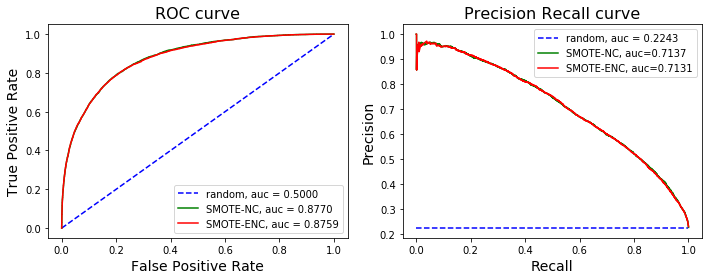

C:\Users\mimi_\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [39]:
##Create ROC-AUC and PR-AUC curve

generate_curves(MODELS / 'rain_smotenc.sav', MODELS / 'rain_mysmotenc.sav', X_test, y_test)

C:\Users\mimi_\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<Figure size 720x720 with 0 Axes>

C:\Users\mimi_\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


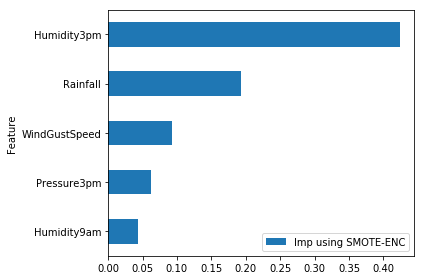

In [48]:
## Find out top 5 most important features using our new SMOTE method

filename = (MODELS / 'rain_mysmotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(5))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using SMOTE-ENC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'rain_newsmote.jpeg', bbox_inches='tight')

C:\Users\mimi_\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<Figure size 720x720 with 0 Axes>

C:\Users\mimi_\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


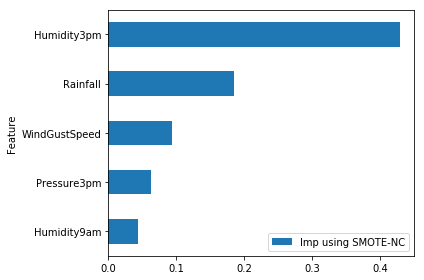

In [41]:
## Find out top 5 most important features using the existing SMOTE method

filename = (MODELS / 'rain_smotenc.sav')
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=X_train.columns).nlargest(5))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using SMOTE-NC']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'rain_oldsmote.jpeg', bbox_inches='tight')